# Azure AI image analysis

Below is example of using Azure AI vision API for image analysis. 
This lab based on https://microsoftlearning.github.io/mslearn-ai-vision/Instructions/Exercises/01-analyze-images.html

In [ ]:
%pip install azure-ai-vision-imageanalysis==1.0.0b3 matplotlib pillow python-dotenv

In [1]:
from dotenv import load_dotenv
import os
from PIL import Image, ImageDraw
import sys
from matplotlib import pyplot as plt
from azure.core.exceptions import HttpResponseError
import requests

from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential

global cv_client

In [2]:
# Get Configuration Settings
load_dotenv()
ai_endpoint = os.getenv('AI_SERVICE_ENDPOINT')
ai_key = os.getenv('AI_SERVICE_KEY')
print(f"Endpoint: {ai_endpoint}")

Endpoint: https://ai-services84921.cognitiveservices.azure.com/


In [6]:
def AnalyzeImage(image_filename, image_data, cv_client):
    """
    Analyze an image using the Azure Cognitive Services Computer Vision API
    """
    try:
        # Get result with specified features to be retrieved
        result = cv_client.analyze(
            image_data=image_data,
            visual_features=[
                VisualFeatures.CAPTION,
                VisualFeatures.DENSE_CAPTIONS,
                VisualFeatures.TAGS,
                VisualFeatures.OBJECTS,
                VisualFeatures.PEOPLE],
        )

    except HttpResponseError as e:
        print(f"Status code: {e.status_code}")
        print(f"Reason: {e.reason}")
        print(f"Message: {e.error.message}")

    # Display the image analysis results
    # Captions
    if result.caption is not None:
        print("\nCaption:")
        print(" Caption: '{}' (confidence: {:.2f}%)".format(result.caption.text, result.caption.confidence * 100))

    # Dense captions
    if result.dense_captions is not None:
        print("\nDense Captions:")
        for caption in result.dense_captions.list:
            print(" Caption: '{}' (confidence: {:.2f}%)".format(caption.text, caption.confidence * 100))

    # Tags
    if result.tags is not None:
        print("\nTags:")
        for tag in result.tags.list:
            print(" Tag: '{}' (confidence: {:.2f}%)".format(tag.name, tag.confidence * 100))


    # Objects in the image
    if result.objects is not None:
        print("\nObjects in image:")

        # Prepare image for drawing
        image = Image.open(image_filename)
        fig = plt.figure(figsize=(image.width/100, image.height/100))
        plt.axis('off')
        draw = ImageDraw.Draw(image)
        color = 'cyan'

        for detected_object in result.objects.list:
            # Print object name
            print(" {} (confidence: {:.2f}%)".format(detected_object.tags[0].name, detected_object.tags[0].confidence * 100))
            
            # Draw object bounding box
            r = detected_object.bounding_box
            bounding_box = ((r.x, r.y), (r.x + r.width, r.y + r.height)) 
            draw.rectangle(bounding_box, outline=color, width=3)
            plt.annotate(detected_object.tags[0].name,(r.x, r.y), backgroundcolor=color)

        # Save annotated image
        plt.imshow(image)
        plt.tight_layout(pad=0)
        output_file = os.path.join (os.getcwd(), "data", "output", "objects.jpg")
        fig.savefig(output_file)
        print('  Results saved in', output_file)

    # People in the image
    if result.people is not None:
        print("\nPeople in image:")

        # Prepare image for drawing
        image = Image.open(image_filename)
        fig = plt.figure(figsize=(image.width/100, image.height/100))
        plt.axis('off')
        draw = ImageDraw.Draw(image)
        color = 'cyan'

        for detected_people in result.people.list:
            # Draw object bounding box
            r = detected_people.bounding_box
            bounding_box = ((r.x, r.y), (r.x + r.width, r.y + r.height))
            draw.rectangle(bounding_box, outline=color, width=3)

            # Return the confidence of the person detected
            print(" {} (confidence: {:.2f}%)".format(detected_people.bounding_box, detected_people.confidence * 100))
            
        # Save annotated image
        plt.imshow(image)
        plt.tight_layout(pad=0)
        output_file = os.path.join (os.getcwd(), "data", "output", "people.jpg")
        fig.savefig(output_file)
        print('  Results saved in', output_file)

In [7]:
def BackgroundForeground(endpoint, key, image_file):
    """
    Image matting or background removal with using the Azure Cognitive Services Computer Vision API
    """
    # Define the API version and mode
    api_version = "2023-02-01-preview"
    mode="backgroundRemoval" # Can be "foregroundMatting" or "backgroundRemoval"
    
    # Remove the background from the image or generate a foreground matte
    print('\nRemoving background from image...')
        
    url = "{}computervision/imageanalysis:segment?api-version={}&mode={}".format(endpoint, api_version, mode)

    headers= {
        "Ocp-Apim-Subscription-Key": key, 
        "Content-Type": "application/json" 
    }

    image_url="https://github.com/MicrosoftLearning/mslearn-ai-vision/blob/main/Labfiles/01-analyze-images/Python/image-analysis/{}?raw=true".format(image_file)  

    body = {
        "url": image_url,
    }
        
    response = requests.post(url, headers=headers, json=body)

    image=response.content
    output_file = os.path.join (os.getcwd(), "data", "output", "background.png")
    with open(output_file, "wb") as file:
        file.write(image)
    print('  Results saved in ', output_file)


Caption:
 Caption: 'a man walking a dog on a leash on a street' (confidence: 82.05%)

Dense Captions:
 Caption: 'a man walking a dog on a leash on a street' (confidence: 82.07%)
 Caption: 'a man walking on a street' (confidence: 69.03%)
 Caption: 'a yellow car on the street' (confidence: 78.22%)
 Caption: 'a black dog walking on the street' (confidence: 75.33%)
 Caption: 'a blurry image of a blue car' (confidence: 82.01%)
 Caption: 'a yellow taxi cab on the street' (confidence: 72.44%)

Tags:
 Tag: 'outdoor' (confidence: 99.87%)
 Tag: 'land vehicle' (confidence: 99.02%)
 Tag: 'vehicle' (confidence: 98.89%)
 Tag: 'building' (confidence: 98.55%)
 Tag: 'road' (confidence: 95.98%)
 Tag: 'wheel' (confidence: 95.14%)
 Tag: 'street' (confidence: 94.71%)
 Tag: 'person' (confidence: 93.01%)
 Tag: 'clothing' (confidence: 91.19%)
 Tag: 'taxi' (confidence: 90.95%)
 Tag: 'car' (confidence: 84.01%)
 Tag: 'dog' (confidence: 82.68%)
 Tag: 'yellow' (confidence: 77.08%)
 Tag: 'walking' (confidence: 74.

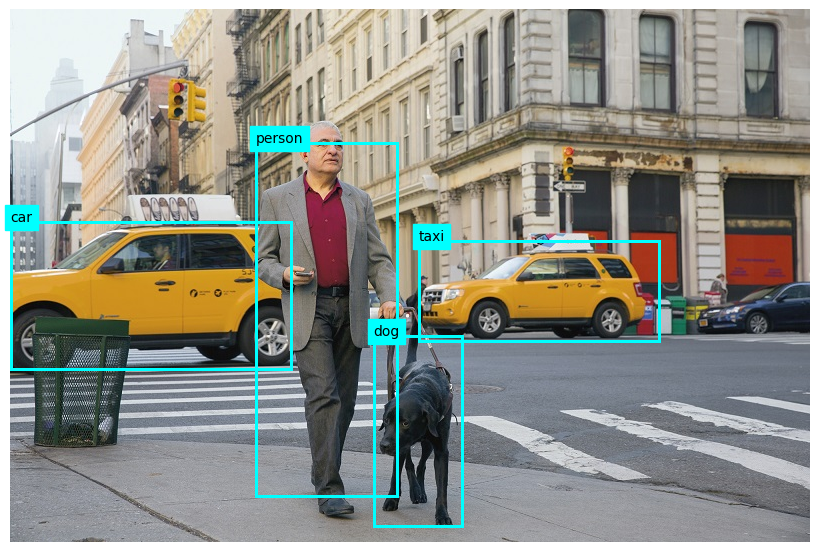

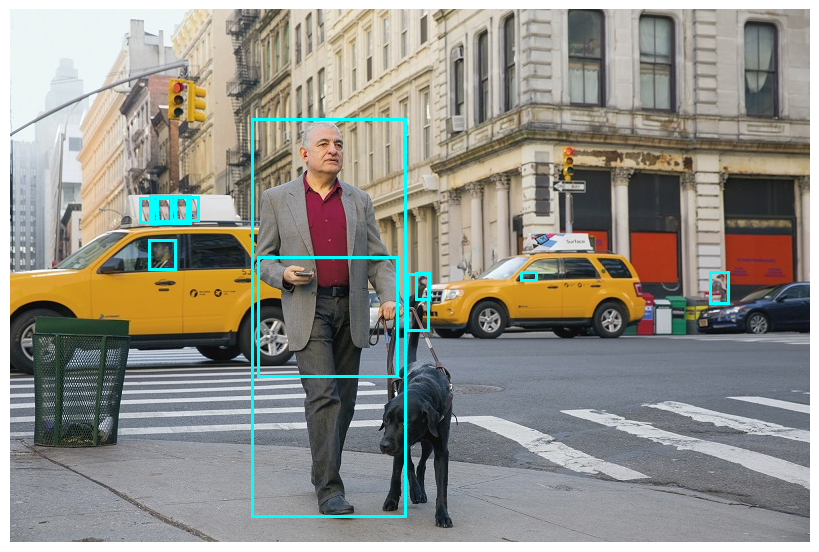

In [9]:
# main
try:
    
    # Get image
    # use the street.jpg image file from the data folder
    image_file = os.path.join (os.getcwd(), "data", "street.jpg")
    with open(image_file, "rb") as f:
        image_data = f.read()

    # Authenticate Azure AI Vision client
    cv_client = ImageAnalysisClient(
        endpoint=ai_endpoint,
        credential=AzureKeyCredential(ai_key)
)        
    # Analyze image
    AnalyzeImage(image_file, image_data, cv_client)
    
    # Background removal
    BackgroundForeground(ai_endpoint, ai_key, image_file)

except Exception as ex:
    print(ex)